In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split,DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [0]:
dataset = FashionMNIST(root = './', train=True, transform=ToTensor(), download=True)
test_ds = FashionMNIST(root = './', train=False, transform=ToTensor())

In [84]:
print(len(dataset))
print(len(test_ds))

60000
10000


In [85]:
dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([1, 28, 28])
9


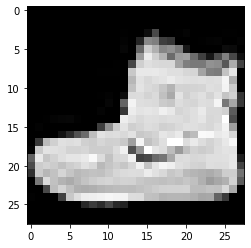

In [86]:
img,label= dataset[0]
print(img.shape)
print(label)
plt.imshow(img[0],cmap='gray')
plt.show()

## Dataset and Dataloader


In [0]:
validation_split=0.1
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [88]:
print(len(train_ds))
print(len(val_ds))

54000
6000


In [0]:
batch_size = 64
train_loader = DataLoader(train_ds,batch_size = batch_size,shuffle = True ,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size = batch_size,shuffle = True ,num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds,batch_size = batch_size,shuffle = True ,num_workers=4, pin_memory=True)

## Visualising a batch of image

images.shape: torch.Size([64, 1, 28, 28])


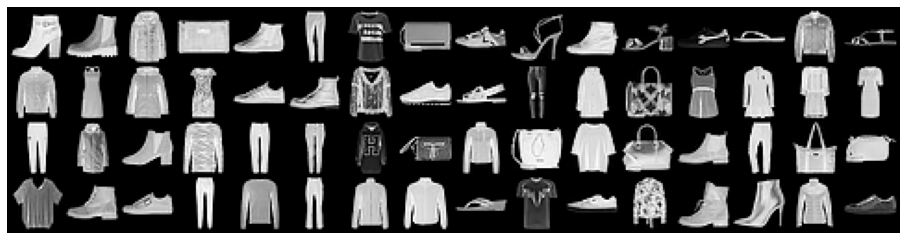

In [90]:
for img,label in train_loader:
  print('images.shape:', img.shape)
  plt.figure(figsize=(16,8))
  plt.imshow(make_grid(img,nrow=16).permute(1,2,0))
  plt.axis('off')
  break

In [0]:
input_shape = 28*28
num_classes = 10

## Building a model

In [0]:
def accuracy(out,labels):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Fashion_mnist(nn.Module):

  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(input_shape,64)
    self.linear2 = nn.Linear(64,128)
    self.linear3 = nn.Linear(128,256)
    self.linear4 = nn.Linear(256,10)


  def forward(self,xb):
    out = xb.reshape(-1,784)
    out = self.linear1(out)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    return out

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_losses = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_acc':epoch_acc.item(),'val_loss':epoch_loss.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], train_loss:{:,.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


## Evaluation and Training

In [0]:
def evaluate(model, val_loader):
   outputs = [model.validation_step(batch) for batch in val_loader]
   return model.validation_epoch_end(outputs)

In [0]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
   history = []
   optimizer = opt_func(model.parameters(), lr)
   for epoch in range(epochs):
     train_loss = []
     for batch in train_loader:
       loss = model.training_step(batch)
       loss.backward()
       train_loss.append(loss)
       optimizer.step()
       optimizer.zero_grad()
     result = evaluate(model, val_loader)
     result['train_loss'] = torch.stack(train_loss).mean().item()
     model.epoch_end(epoch, result)
     history.append(result)
   return history

## Using GPU

In [0]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Ploting loss and accuracy

In [0]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [0]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [96]:
device = get_default_device()
device

device(type='cuda')

In [0]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader,device)

In [0]:
model = to_device(Fashion_mnist(),device)

In [99]:
evaluate(model, val_loader)

{'val_acc': 0.099678635597229, 'val_loss': 2.304870128631592}

## Traing the model

In [100]:
history = fit(10,0.001, model, train_loader, val_loader,opt_func=torch.optim.Adam)

Epoch [0], train_loss:0.5774, val_loss: 0.4495, val_acc: 0.8397
Epoch [1], train_loss:0.3973, val_loss: 0.3952, val_acc: 0.8643
Epoch [2], train_loss:0.3588, val_loss: 0.3770, val_acc: 0.8686
Epoch [3], train_loss:0.3309, val_loss: 0.3565, val_acc: 0.8678
Epoch [4], train_loss:0.3133, val_loss: 0.3375, val_acc: 0.8789
Epoch [5], train_loss:0.3003, val_loss: 0.3257, val_acc: 0.8807
Epoch [6], train_loss:0.2845, val_loss: 0.3301, val_acc: 0.8838
Epoch [7], train_loss:0.2723, val_loss: 0.3237, val_acc: 0.8864
Epoch [8], train_loss:0.2621, val_loss: 0.3114, val_acc: 0.8882
Epoch [9], train_loss:0.2507, val_loss: 0.3456, val_acc: 0.8820


In [101]:
history += fit(5,0.001, model, train_loader, val_loader,opt_func=torch.optim.Adam)

Epoch [0], train_loss:0.2456, val_loss: 0.3549, val_acc: 0.8802
Epoch [1], train_loss:0.2352, val_loss: 0.3500, val_acc: 0.8805
Epoch [2], train_loss:0.2289, val_loss: 0.3598, val_acc: 0.8791
Epoch [3], train_loss:0.2200, val_loss: 0.3187, val_acc: 0.8943
Epoch [4], train_loss:0.2177, val_loss: 0.3160, val_acc: 0.8971


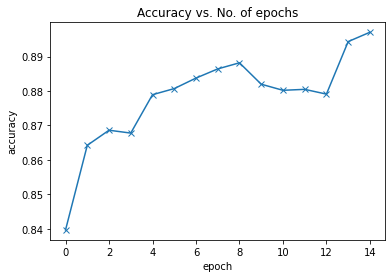

In [104]:
plot_accuracies(history)

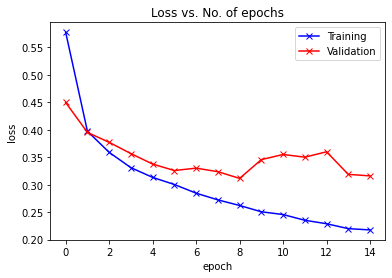

In [105]:
plot_losses(history)

## Evaluating the model in test dataset


In [108]:
evaluate(model,test_loader)

{'val_acc': 0.8865445852279663, 'val_loss': 0.3372742533683777}